NOTE: This notebook is assuming you have the `daily_dataset.csv` inside the folder local_data in data, and the `pernoctacions_2019_2024.csv`, `temperature_precipitation.csv` and `tourism_flux.csv` datasets inside the folder data.

The `daily_dataset.csv` should be exactly how it is when it is being recently downloaded from the AB Datachallenge portal.

In [36]:
import pandas as pd
from collections import Counter
import seaborn as sns
import os
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [37]:
# Load the datasets
pernoctacions = pd.read_csv('../data/pernoctacions_2019_2024.csv')
tourism = pd.read_csv('../data/tourism_flux.csv')
clima_df = pd.read_csv('../data/temperature_precipitation.csv')

In [38]:
# Convert the 'Day' column to datetime with specified format
tourism['Day'] = pd.to_datetime(tourism['Day'], format='%m/%d/%Y', errors='coerce')

# Group by month and year to calculate total flights per month
monthly_flights = tourism.groupby(tourism['Day'].dt.to_period('M'))['Flights'].sum().reset_index()
monthly_flights.columns = ['Month', 'Total Flights']

# Merge with original DataFrame to calculate percentage
flights_df = tourism.merge(monthly_flights, left_on=tourism['Day'].dt.to_period('M'), right_on='Month', how='left')

# Calculate percentage of flights
flights_df['Percentage of Flights'] = (flights_df['Flights'] / flights_df['Total Flights']) * 100

# Clean up DataFrame
flights_df.drop(columns=['Month'], inplace=True)


In [39]:
# Convertir las fechas en ambos datasets al mismo formato
pernoctacions['Data'] = pd.to_datetime(pernoctacions['Data'], format='%m/%d/%Y')
flights_df['Day'] = pd.to_datetime(flights_df['Day'])
pernoctacions['Pernoctacions'] = pd.to_numeric(pernoctacions['Pernoctacions'].str.replace('.', ''), errors='coerce')

# Iterar sobre los meses de pernoctaciones y distribuir según los porcentajes diarios de vuelos
resultados = []

for _, row in pernoctacions.iterrows():
    # Extraer el mes y año
    mes = row['Data'].month
    anyo = row['Data'].year
    pernoctaciones_mensuales = row['Pernoctacions']
    
    # Filtrar los vuelos de ese mes y año
    vuelos_mes = flights_df[(flights_df['Day'].dt.month == mes) & (flights_df['Day'].dt.year == anyo)]
    
    # Normalizar los porcentajes de vuelos
    vuelos_mes['Percentage of Flights'] = vuelos_mes['Percentage of Flights'] / vuelos_mes['Percentage of Flights'].sum()
    
    # Distribuir las pernoctaciones diarias
    for _, vuelo in vuelos_mes.iterrows():
        pernoctaciones_diarias = round(int(pernoctaciones_mensuales) * vuelo['Percentage of Flights'])
        resultados.append({
            'Day': vuelo['Day'],
            'tipus allotjament': row['Tipologia d\'allotjament'],
            'pernoctacions': pernoctaciones_diarias
        })

# Crear el DataFrame final
resultado_df = pd.DataFrame(resultados)

# Don't print warnings
pd.options.mode.chained_assignment = None

In [40]:
resultado_df = resultado_df.sort_values(by='Day', ascending=False)

In [41]:
clima_df = clima_df.groupby('fecha').agg({
    'temp_max': 'mean',
    'temp_min': 'mean',
    'precipitacion': 'mean'
}).round(2).reset_index()


In [42]:
# Convertir la columna 'fecha' a formato datetime
clima_df['fecha'] = pd.to_datetime(clima_df['fecha'])

# Asegurarse de que la columna 'Day' en resultado_df esté en formato datetime
resultado_df['Day'] = pd.to_datetime(resultado_df['Day'])

# Hacer el merge por la columna de fecha (Day en resultado_df y fecha en clima_df)
merged_df = pd.merge(resultado_df, clima_df, left_on='Day', right_on='fecha', how='left')

In [43]:
# Step 1: Remove the `fecha` column
df = merged_df.drop(columns=['fecha'])

# Step 2: Pivot the data
df_pivoted = df.pivot_table(
    index=["Day", "temp_max", "temp_min", "precipitacion"],
    columns="tipus allotjament",
    values="pernoctacions",
    fill_value=0  # Optional: fill missing values with 0
).reset_index()

# Step 3: Rename columns
df_pivoted.columns = [
    "Day", "temp_max", "temp_min", "precipitacion",
    "Pernoctacions_Albergs", "Pernoctacions_Habitatge_turístic", "Pernoctacions_Hotel"
]

# Step 4: Add `Pernoctacions_Albergs` to `Pernoctacions_Hotel`
df_pivoted["Pernoctacions_Hotel"] += df_pivoted["Pernoctacions_Albergs"]

# Step 5: Drop `Pernoctacions_Albergs` column
df_pivoted = df_pivoted.drop(columns=["Pernoctacions_Albergs"])

#Change Day format
df_pivoted['Day'] = pd.to_datetime(df_pivoted['Day']).dt.strftime('%d-%m-%Y')

In [44]:
df_pivoted.head()

,Day,temp_max,temp_min,precipitacion,Pernoctacions_Habitatge_turístic,Pernoctacions_Hotel
0,01-01-2021,7.55,4.30,5.65,3500,8700
1,02-01-2021,8.55,1.55,0.00,6369,15828
2,03-01-2021,9.55,0.85,0.00,6904,17160
3,04-01-2021,10.10,0.65,0.00,5825,14478
4,05-01-2021,9.40,0.65,0.00,4669,11603


In [45]:
# df_pivoted.to_csv('../data/Preprocessed_Data/Tourism_Temp_bcn.csv', index=False)
tourism_temp_bcn = df_pivoted

### End of Martí's code

In [46]:
daily_aigues = pd.read_csv("../data/local_data/daily_dataset.csv", encoding='latin1')
daily_aigues.tail()

,Secció censal/Sección censal/Census section,Districte/Distrito/District,Municipi/Municipio/Municipality,Data/Fecha/Date,Ús/Uso/Use,Nombre de comptadors/Número de contadores/Number of meters,Consum acumulat (L/dia)/Consumo acumulado (L/día)/Accumulated consumption (L/day)
15834,0810106032,06,L'HOSPITALET LLOBR.,2023-01-30,Domèstic/Doméstico/Domestic,325,4824
15835,0810106032,06,L'HOSPITALET LLOBR.,2023-01-30,Industrial/Industrial/Industrial,2,2141
15836,0810106032,06,L'HOSPITALET LLOBR.,2023-01-31,Comercial/Comercial/Commercial,10,5336
15837,0810106032,06,L'HOSPITALET LLOBR.,2023-01-31,Domèstic/Doméstico/Domestic,325,5054
15838,0810106032,06,L'HOSPITALET LLOBR.,2023-01-31,Industrial/Industrial/Industrial,2,2163


In [47]:
daily_aigues = daily_aigues.rename(columns={
    daily_aigues.columns[0]: 'Census Section',
    daily_aigues.columns[1]: 'District',
    daily_aigues.columns[2]: 'Municipality',
    daily_aigues.columns[3]: 'Date',
    daily_aigues.columns[4]: 'Use',
    daily_aigues.columns[5]: 'Number of Meters',
    daily_aigues.columns[6]: 'Accumulated Consumption'
})

daily_aigues['Date'] = pd.to_datetime(daily_aigues['Date'])

daily_aigues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15839 entries, 0 to 15838
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Census Section           15839 non-null  object        
 1   District                 15839 non-null  object        
 2   Municipality             15839 non-null  object        
 3   Date                     15839 non-null  datetime64[ns]
 4   Use                      15839 non-null  object        
 5   Number of Meters         15839 non-null  int64         
 6   Accumulated Consumption  15839 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 866.3+ KB


In [48]:
daily_aigues['Use'] = daily_aigues['Use'].replace({
    'Comercial/Comercial/Commercial': 'Commercial',
    'DomÃ¨stic/DomÃ©stico/Domestic': 'Domestic',
    'Industrial/Industrial/Industrial': 'Industrial'
})

daily_aigues['Use'].unique()

array(['Commercial', 'Domèstic/Doméstico/Domestic', 'Industrial'],
      dtype=object)

In [49]:
daily_aigues['Municipality'].unique()

array(["L'HOSPITALET LLOBR."], dtype=object)

In [50]:
daily_aigues_bcn = daily_aigues[daily_aigues['Municipality'] == 'BARCELONA'].drop(columns=["Municipality"])

In [51]:
daily_aigues_bcn.tail(20)

,Census Section,District,Date,Use,Number of Meters,Accumulated Consumption


In [52]:
daily_aigues_bcn.shape

(0, 6)

In [53]:
# tourism_temp_bcn imported from Marti's code above
# tourism_temp_bcn = pd.read_csv("../data/tourism_temp_bcn.csv")
tourism_temp_bcn.head()

,Day,temp_max,temp_min,precipitacion,Pernoctacions_Habitatge_turístic,Pernoctacions_Hotel
0,01-01-2021,7.55,4.30,5.65,3500,8700
1,02-01-2021,8.55,1.55,0.00,6369,15828
2,03-01-2021,9.55,0.85,0.00,6904,17160
3,04-01-2021,10.10,0.65,0.00,5825,14478
4,05-01-2021,9.40,0.65,0.00,4669,11603


In [54]:
tourism_temp_bcn = tourism_temp_bcn.rename(columns={
    tourism_temp_bcn.columns.values[0] : 'Day',
    tourism_temp_bcn.columns.values[1] : 'Max Temperature',
    tourism_temp_bcn.columns.values[2] : 'Min Temperature',
    tourism_temp_bcn.columns.values[3] : 'Precipitation',
    tourism_temp_bcn.columns.values[4] : 'Tourist Accommodations',
    tourism_temp_bcn.columns.values[5] : 'Hotel Overnight Stays'
})

tourism_temp_bcn['Day'] = pd.to_datetime(tourism_temp_bcn['Day'], format="%d-%m-%Y")

In [55]:
tourism_temp_bcn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Day                     1095 non-null   datetime64[ns]
 1   Max Temperature         1095 non-null   float64       
 2   Min Temperature         1095 non-null   float64       
 3   Precipitation           1095 non-null   float64       
 4   Tourist Accommodations  1095 non-null   int64         
 5   Hotel Overnight Stays   1095 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 51.5 KB


In [56]:
merged_data = (daily_aigues_bcn.merge(tourism_temp_bcn, left_on='Date', right_on='Day', how='left')).drop(columns=["Day"])

In [57]:
merged_data.shape

(0, 11)

In [58]:
merged_data.head(5)

,Census Section,District,Date,Use,Number of Meters,Accumulated Consumption,Max Temperature,Min Temperature,Precipitation,Tourist Accommodations,Hotel Overnight Stays


In [59]:
# one_hot_encoded = pd.get_dummies(merged_data)

### End of Yuyan's code

In [60]:
# the column hotel overnight stays has a .0 at the end and it should be int. Let's fix it
merged_data['Hotel Overnight Stays'] = merged_data['Hotel Overnight Stays'].astype(int)

In [61]:
merged_data.isna().sum()

Census Section             0.0
District                   0.0
Date                       0.0
Use                        0.0
Number of Meters           0.0
Accumulated Consumption    0.0
Max Temperature            0.0
Min Temperature            0.0
Precipitation              0.0
Tourist Accommodations     0.0
Hotel Overnight Stays      0.0
dtype: float64

In [62]:
# As the columns census section and district contain some nulls, we will drop the rows with nulls in these columns
merged_data = merged_data.dropna(subset=['Census Section', 'District'])

In [63]:
merged_data.isna().sum()

Census Section             0.0
District                   0.0
Date                       0.0
Use                        0.0
Number of Meters           0.0
Accumulated Consumption    0.0
Max Temperature            0.0
Min Temperature            0.0
Precipitation              0.0
Tourist Accommodations     0.0
Hotel Overnight Stays      0.0
dtype: float64

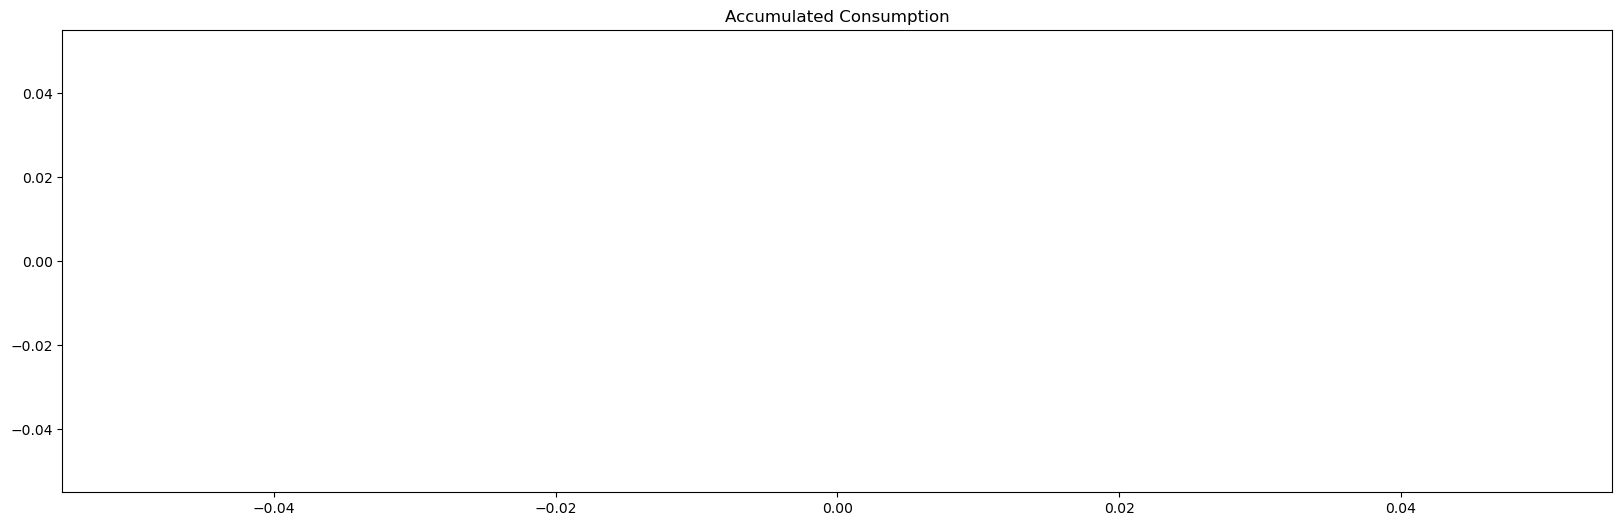

In [64]:
# plot the accumulated consumption to detect outliers
plt.figure(figsize=(20, 6))
plt.plot(merged_data['Accumulated Consumption'])
plt.title('Accumulated Consumption')
plt.show()

In [65]:
# Drop all the accumulated consumption values below 0
merged_data = merged_data[merged_data['Accumulated Consumption'] > 0]

In [66]:
merged_data.describe()

,Date,Number of Meters,Accumulated Consumption,Max Temperature,Min Temperature,Precipitation,Tourist Accommodations,Hotel Overnight Stays
count,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
# There's a couple of observations with the Census Section and the District columns that are <NULL> and >. We will drop these rows
merged_data = merged_data[merged_data['Census Section'] != '<NULL>']
merged_data = merged_data[merged_data['District'] != '>']
merged_cleaned_data = merged_data

In [68]:
# Save CSV data

# Create the directory if it does not exist
os.makedirs('../data/local_data/', exist_ok=True)

# Save the cleaned dataset
merged_cleaned_data.to_csv('../data/local_data/merged_cleaned_data.csv', index=False)

In [69]:
merged_cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Census Section           0 non-null      object        
 1   District                 0 non-null      object        
 2   Date                     0 non-null      datetime64[ns]
 3   Use                      0 non-null      object        
 4   Number of Meters         0 non-null      int64         
 5   Accumulated Consumption  0 non-null      int64         
 6   Max Temperature          0 non-null      float64       
 7   Min Temperature          0 non-null      float64       
 8   Precipitation            0 non-null      float64       
 9   Tourist Accommodations   0 non-null      int64         
 10  Hotel Overnight Stays    0 non-null      int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(3)
memory usage: 132.0+ bytes


In [70]:
merged_cleaned_data.describe()

,Date,Number of Meters,Accumulated Consumption,Max Temperature,Min Temperature,Precipitation,Tourist Accommodations,Hotel Overnight Stays
count,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
